In [1]:
import xarray as xr
import rioxarray as rxr
import uavgeo as ug
import numpy as np
import geopandas as gpd

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\uavgeo\compute\products.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### load and visualize vineyard data

Downloaded and placed under `/dataset/altum_vinyeard_segmentation` folder

three locations: esac, qbaxio, valdoeiro
1. TRAIN = ESAC1
2. VAL = ESAC2
3. TEST = qbaixo (t4 result in paper), valdoeiro (t1 result in paper)




In [2]:
ortho = "../dataset/altum_vineyard_segmentation/esac/altum/ortho.tif"
mask = "../dataset/altum_vineyard_segmentation/esac/altum/mask.png"

esac_ortho = rxr.open_rasterio(ortho, masked =True)
esac_mask = rxr.open_rasterio(mask, masked =True)

qbaixo_ortho = rxr.open_rasterio(ortho.replace("esac", "qbaixo"), masked =True)
qbaixo_mask =rxr.open_rasterio(mask.replace("esac", "qbaixo"), masked =True)

valdoeiro_ortho = rxr.open_rasterio(ortho.replace("esac", "valdoeiro"), masked =True)
valdoeiro_mask = rxr.open_rasterio(mask.replace("esac", "valdoeiro").replace(".png", ".tif"), masked =True)

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [3]:
# aligning the esac mask to ms rasters:
# Esac has the identical shape so we can just plop the values into the shape/crs  
# one layer has all the info we need
esac_mask = esac_mask.sel(band=1)
empty = xr.zeros_like(esac_ortho.sel(band=2))

empty.values = esac_mask.values

esac_mask = empty.copy()

In [4]:
# has some gaping holes (we can fix that later y only selecting chips without edges? hmmm

# aligning the esac mask to ms rasters:
# Esac has the identical shape so we can just plop the values into the shape/crs  
# one layer has all the info we need
qbaixo_mask = qbaixo_mask.sel(band=1)
empty = xr.zeros_like(qbaixo_ortho.sel(band=2))

empty.values =qbaixo_mask.values

qbaixo_mask = empty.copy()


In [5]:
# Get the shapes of both rasters
ortho_shape = valdoeiro_ortho.shape
mask_shape = valdoeiro_mask.shape

# Calculate the difference in size
height_diff = ortho_shape[1] - mask_shape[1]  # Difference in y dimension
width_diff = ortho_shape[2] - mask_shape[2]   # Difference in x dimension

# Crop the ortho to match the mask size, keeping the alignment from top right
# This means we'll remove pixels from the bottom and left
cropped_ortho = valdoeiro_ortho.isel(
    y=slice(0, mask_shape[1]),           # Keep the top portion
    x=slice(width_diff, ortho_shape[2])  # Keep the right portion
)
empty = xr.zeros_like(cropped_ortho.sel(band=2))

empty.values =valdoeiro_mask.sel(band=1).values

valdoeiro_mask = empty.copy()
valdoeiro_ortho = cropped_ortho.copy()

### preprocess bands
4 band: G, R, RE, NIR

original dataset is from an Altum-PT

1. select bands
2. normalize bands (min-max scaling, save as 8bit tif)

In [6]:
bands = [2,3,4,5] #(GREEN, RED,REDEDGE,NIR)
esac_ortho = esac_ortho.sel(band=bands)
esac_ortho = 255.0 * (esac_ortho - esac_ortho.min()) / (esac_ortho.max() - esac_ortho.min())
esac_ortho = esac_ortho.astype(np.uint8)

valdoeiro_ortho = valdoeiro_ortho.sel(band=bands)
valdoeiro_ortho = 255.0 * (valdoeiro_ortho - valdoeiro_ortho.min()) / (valdoeiro_ortho.max() - valdoeiro_ortho.min())
valdoeiro_ortho = valdoeiro_ortho.astype(np.uint8)

qbaixo_ortho = qbaixo_ortho.sel(band=bands)
qbaixo_ortho = 255.0 * (qbaixo_ortho - qbaixo_ortho.min()) / (qbaixo_ortho.max() - qbaixo_ortho.min())
qbaixo_ortho = qbaixo_ortho.astype(np.uint8)

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\xarray\core\duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\xarray\core\duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\xarray\core\duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


### Subset esac1 +esac2 from tif

In [7]:
# Make esac 1 and esac 2, like the study
esac_shp = gpd.read_file("../dataset/altum_vineyard_segmentation/esac/esac12.geojson")
esac1_geom = esac_shp.geometry[esac_shp["id"]==1]
esac2_geom = esac_shp.geometry[esac_shp["id"]==2]

esac1_ortho = esac_ortho.rio.clip(esac1_geom.values, esac_shp.crs)
esac2_ortho = esac_ortho.rio.clip(esac2_geom.values, esac_shp.crs)

esac1_mask = esac_mask.rio.clip(esac1_geom.values, esac_shp.crs)
esac2_mask = esac_mask.rio.clip(esac2_geom.values, esac_shp.crs)

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\xarray\core\duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\xarray\core\duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


### chip the bands using the ug chip method; spatial/image related


In [8]:
def generate_chips(raster, dims):

        
    # the size of the total orthomosaic defines the shape
    s_x = raster.shape[2] 
    s_y=raster.shape[1] 
    # and a crs to apply to the GDF
    crs = raster.rio.crs
    
    gdf = ug.compute.create_chip_bounds_gdf(input_dims = input_dims, shape_x = s_x, shape_y = s_y, crs = crs)
    
    # let's fix those coordinates, by looking those coordinates up in the the input-raster.
    
    #first find all these coordinates in the raster
    gdf = ug.compute.imgref_to_crsref_boxes(raster=raster, gdf = gdf)
    
    # then apply this column as the new geometry columns
    gdf.set_geometry("c_geom", crs= crs,inplace=True)

    if 'geometry' in gdf.columns and gdf._geometry_column_name != 'geometry':
        gdf = gdf.drop(columns=['geometry'])
    
    return gdf.rename_geometry("geometry")
    
def remove_outlier_chips(gdf, ortho,perc=20):
        
    # First, collect info about which chips are all zeros
    valid_indices = []
    valid_chip_gdf_indices = []
    
    for i, row in gdf.iterrows():
        # Clip the image to the geometry bounds
        clipped_img = ortho.rio.clip_box(
            minx=row.geometry.bounds[0],
            miny=row.geometry.bounds[1],
            maxx=row.geometry.bounds[2], 
            maxy=row.geometry.bounds[3]
        )
        
        # Count zeros
        # For multi-band images, consider a pixel as zero if all bands are zero
        if len(clipped_img.data.shape) > 2:  # Multi-band case
            # Check each pixel across all bands
            zeros_count = np.sum(np.all(clipped_img.data == 0, axis=0))
        else:  # Single band case
            zeros_count = np.sum(clipped_img.data == 0)
        
        # Calculate percentage of zeros
        total_pixels = clipped_img.data.size / (len(clipped_img.data.shape) if len(clipped_img.data.shape) > 2 else 1)
        zero_percentage = (zeros_count / total_pixels) * 100
        
        # Keep if less than 20% zeros (more than 80% non-zero)
        if zero_percentage < perc:
            valid_indices.append(len(valid_indices))
            valid_chip_gdf_indices.append(i)
    return gdf.loc[valid_chip_gdf_indices]


In [9]:

# define the size of the chips
input_dims = {"x":224, "y":224}

esac1_chip_gdf = generate_chips(esac1_ortho, input_dims)
esac1_chip_gdf = remove_outlier_chips(esac1_chip_gdf, esac1_ortho)
esac1_chip_gdf = remove_outlier_chips(esac1_chip_gdf, esac1_mask, perc=99)
esac1_chip_gdf.to_file("../dataset/vineseg/esac1_chips.geojson")

esac2_chip_gdf = generate_chips(esac2_ortho, input_dims)
esac2_chip_gdf = remove_outlier_chips(esac2_chip_gdf, esac2_ortho)
esac2_chip_gdf = remove_outlier_chips(esac2_chip_gdf, esac2_mask, perc=99)
esac2_chip_gdf.to_file("../dataset/vineseg/esac2_chips.geojson")

valdoeiro_chip_gdf = generate_chips(valdoeiro_ortho, input_dims)
valdoeiro_chip_gdf = remove_outlier_chips(valdoeiro_chip_gdf, valdoeiro_ortho)
valdoeiro_chip_gdf = remove_outlier_chips(valdoeiro_chip_gdf, valdoeiro_mask, perc=99)
valdoeiro_chip_gdf.to_file("../dataset/vineseg/valdoeiro_chips.geojson")

qbaixo_chip_gdf = generate_chips(qbaixo_ortho, input_dims)
qbaixo_chip_gdf = remove_outlier_chips(qbaixo_chip_gdf, qbaixo_ortho)
qbaixo_chip_gdf = remove_outlier_chips(qbaixo_chip_gdf, qbaixo_mask, perc=95)
qbaixo_chip_gdf.to_file("../dataset/vineseg/qbaixo_chips.geojson")

In [10]:
def get_stratified_samples(gdf, seed=48):
    """
    Get 1, 5, and 10 random indices from a GeoDataFrame
    where the 5 indices include the first index, and the 10 indices include all 5
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        The GeoDataFrame to sample from
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    tuple : (sample_1, sample_5, sample_10) where each sample is a list of indices
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Get total number of rows
    n_rows = len(gdf)
    
    # Generate all possible indices
    all_indices = np.arange(n_rows)
    
    # Get the first sample (1 index)
    sample_1 = np.random.choice(all_indices, size=1, replace=False).tolist()
    
    # Get 4 more indices for sample_5 (excluding those already in sample_1)
    remaining_indices = np.setdiff1d(all_indices, sample_1)
    sample_4_more = np.random.choice(remaining_indices, size=4, replace=False).tolist()
    sample_5 = sample_1 + sample_4_more
    
    # Get 5 more indices for sample_10 (excluding those already in sample_5)
    remaining_indices = np.setdiff1d(all_indices, sample_5)
    sample_5_more = np.random.choice(remaining_indices, size=5, replace=False).tolist()
    sample_10 = sample_5 + sample_5_more
    
    return sample_1, sample_5, sample_10

# Example usage
sample_1, sample_5, sample_10 = get_stratified_samples(esac1_chip_gdf)

gdf_sample_1 = esac1_chip_gdf.iloc[sample_1]
gdf_sample_5 = esac1_chip_gdf.iloc[sample_5]
gdf_sample_10 = esac1_chip_gdf.iloc[sample_10]

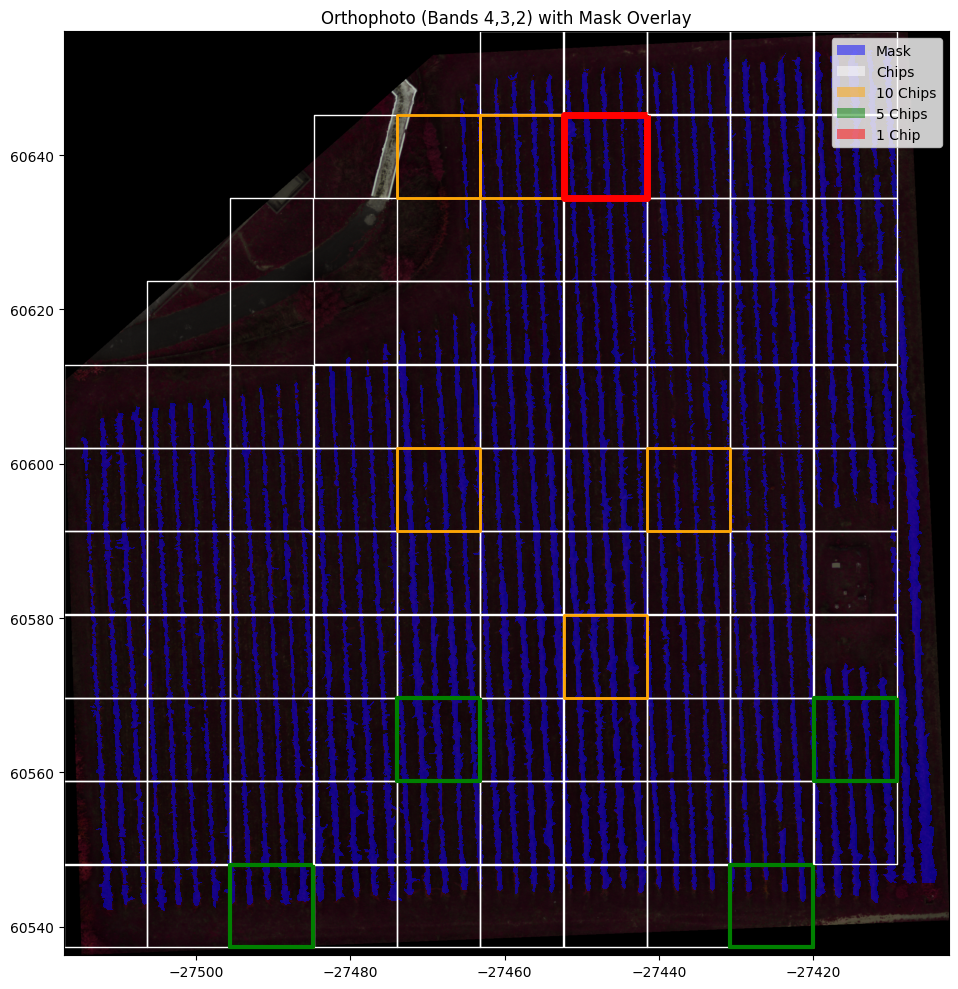

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 10))
esac1_chip_gdf.plot(ax=ax,facecolor="none", edgecolor="white")


gdf_sample_10.plot(ax=ax,facecolor="none", edgecolor = "orange", linewidth =2)

gdf_sample_5.plot(ax=ax,facecolor="none", edgecolor = "green", linewidth=3)

gdf_sample_1.plot(ax=ax,facecolor="none", edgecolor = "red", linewidth=5)

rgb = esac1_ortho.sel(band=[4,3,2]).values.transpose(1,2,0)
e = [esac1_ortho.x.min(), esac1_ortho.x.max(), 
                       esac1_ortho.y.min(), esac1_ortho.y.max()]
# Display the RGB image
ax.imshow(rgb, extent=e)

# Create a mask for the 255 values (the actual mask)
mask_data = esac1_mask.values
mask_binary = np.where(mask_data == 255, 1, 0)  # Convert 255 to 1 for plotting

# Create a colormap where 0 is fully transparent and 1 (originally 255) is semi-transparent red
mask_cmap = ListedColormap(['none', 'blue'])

# Plot the mask with transparency
mask = ax.imshow(mask_binary, cmap=mask_cmap, alpha=0.5, 
                extent=e)

# Add a title
plt.title('Orthophoto (Bands 4,3,2) with Mask Overlay')

# Add a custom legend instead of a colorbar
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.5, label='Mask'),
                  Patch(facecolor='white', alpha=0.5, label='Chips'),
                  Patch(facecolor='orange', alpha=0.5, label='10 Chips'),
                  Patch(facecolor='green', alpha=0.5, label='5 Chips'),
                  Patch(facecolor='red', alpha=0.5, label='1 Chip'),]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

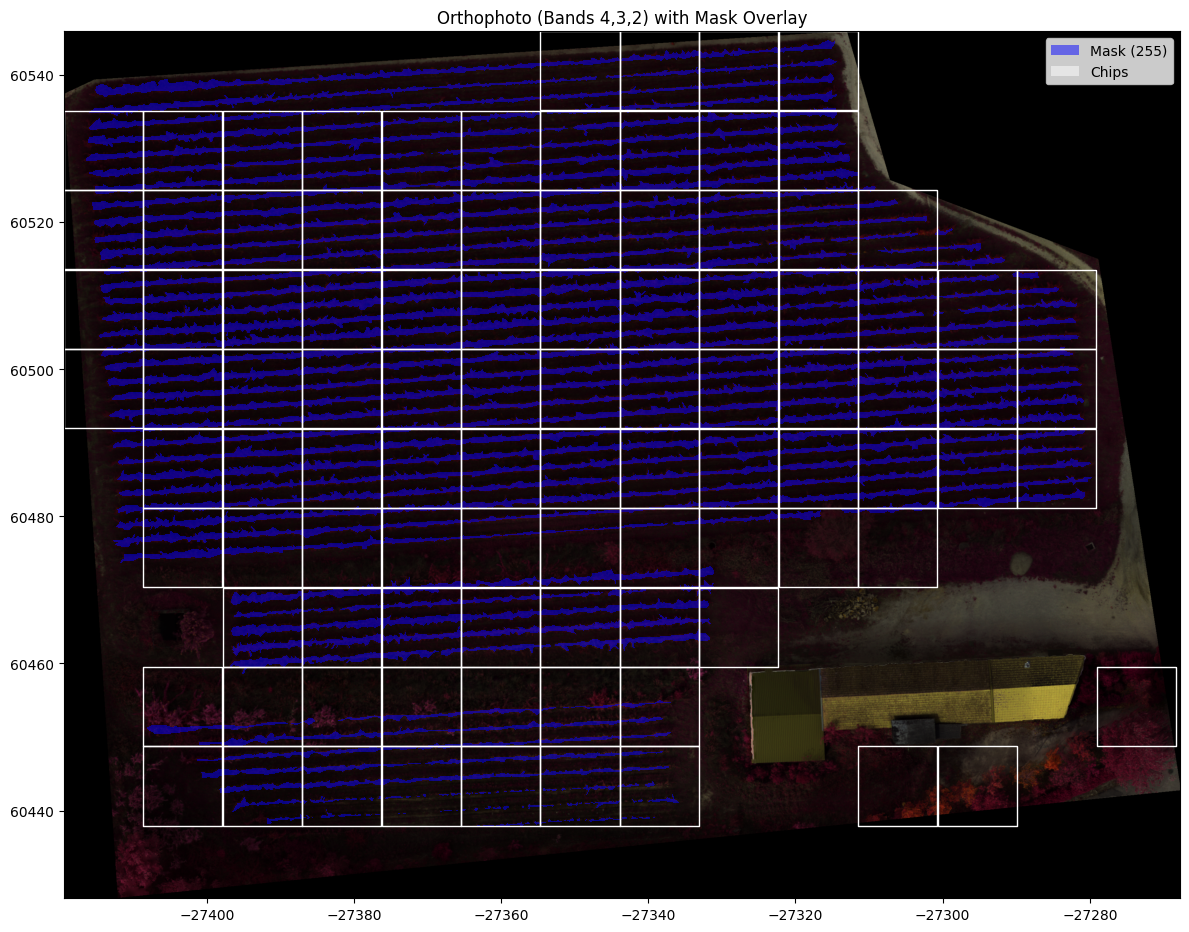

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 10))
esac2_chip_gdf.plot(ax=ax,facecolor="none", edgecolor= "white")
rgb = esac2_ortho.sel(band=[4,3,2]).values.transpose(1,2,0)
e = [esac2_ortho.x.min(), esac2_ortho.x.max(), 
                       esac2_ortho.y.min(), esac2_ortho.y.max()]
# Display the RGB image
ax.imshow(rgb, extent=e)

# Create a mask for the 255 values (the actual mask)
mask_data = esac2_mask.values
mask_binary = np.where(mask_data == 255, 1, 0)  # Convert 255 to 1 for plotting

# Create a colormap where 0 is fully transparent and 1 (originally 255) is semi-transparent red
mask_cmap = ListedColormap(['none', 'blue'])

# Plot the mask with transparency
mask = ax.imshow(mask_binary, cmap=mask_cmap, alpha=0.5, 
                extent=e)

# Add a title
plt.title('Orthophoto (Bands 4,3,2) with Mask Overlay')

# Add a custom legend instead of a colorbar
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.5, label='Mask (255)'),
                  Patch(facecolor='white', alpha=0.5, label='Chips')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

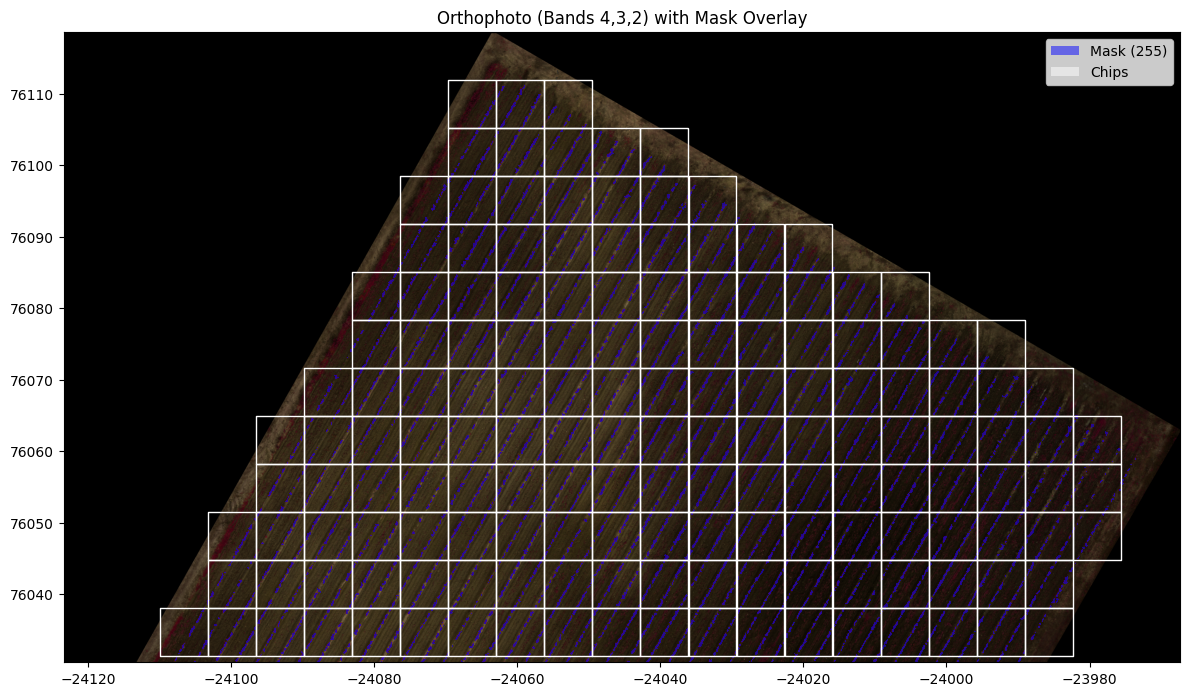

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 10))
valdoeiro_chip_gdf.plot(ax=ax,facecolor="none", edgecolor= "white")
rgb = valdoeiro_ortho.sel(band=[4,3,2]).values.transpose(1,2,0)
e = [valdoeiro_ortho.x.min(), valdoeiro_ortho.x.max(), 
                       valdoeiro_ortho.y.min(), valdoeiro_ortho.y.max()]
# Display the RGB image
ax.imshow(rgb, extent=e)

# Create a mask for the 255 values (the actual mask)
mask_data = valdoeiro_mask.values
mask_binary = np.where(mask_data == 255, 1, 0)  # Convert 255 to 1 for plotting

# Create a colormap where 0 is fully transparent and 1 (originally 255) is semi-transparent red
mask_cmap = ListedColormap(['none', 'blue'])

# Plot the mask with transparency
mask = ax.imshow(mask_binary, cmap=mask_cmap, alpha=0.5, 
                extent=e)

# Add a title
plt.title('Orthophoto (Bands 4,3,2) with Mask Overlay')

# Add a custom legend instead of a colorbar
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.5, label='Mask (255)'),
                   Patch(facecolor='white', alpha=0.5, label='Chips')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

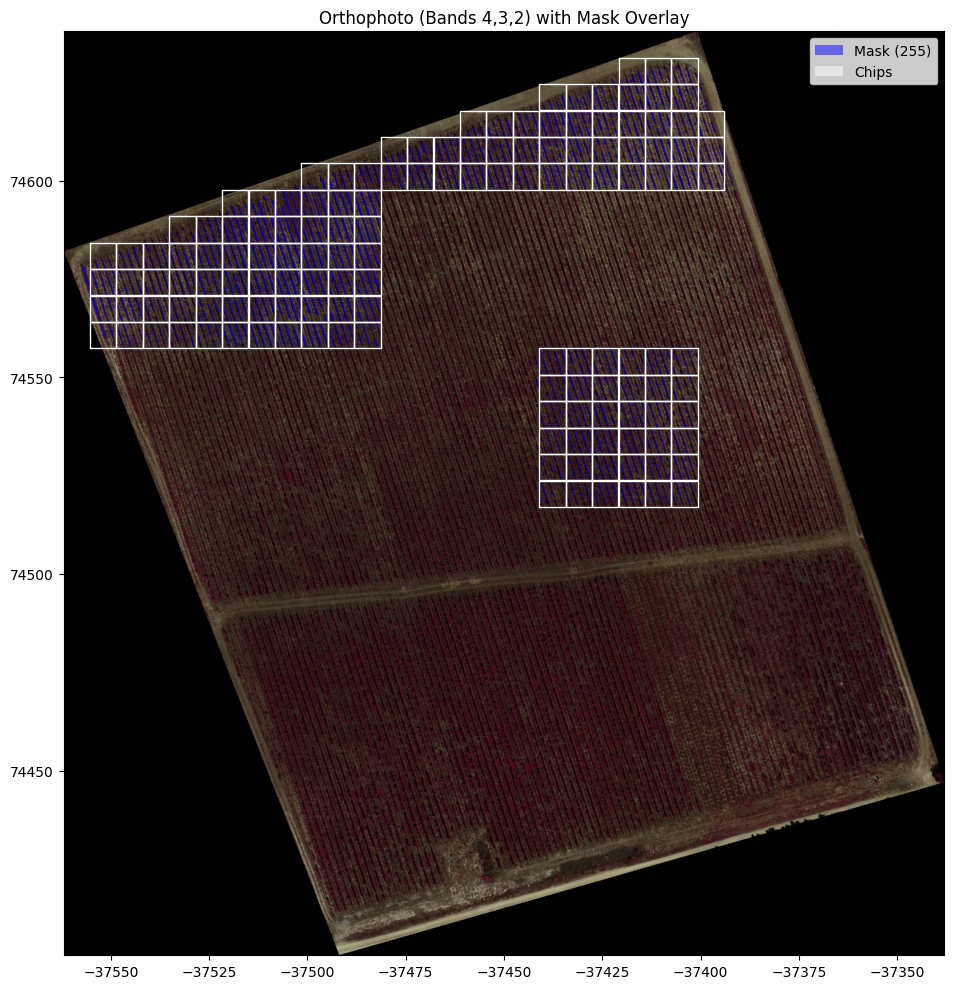

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 10))

rgb = qbaixo_ortho.sel(band=[4,3,2]).values.transpose(1,2,0)
qbaixo_chip_gdf.plot(ax=ax,facecolor="none", edgecolor="white")
# Display the RGB image
ax.imshow(rgb, extent=[qbaixo_ortho.x.min(), qbaixo_ortho.x.max(), 
                       qbaixo_ortho.y.min(), qbaixo_ortho.y.max()])

# Create a mask for the 255 values (the actual mask)
mask_data = qbaixo_mask.values
mask_binary = np.where(mask_data == 255, 1, 0)  # Convert 255 to 1 for plotting

# Create a colormap where 0 is fully transparent and 1 (originally 255) is semi-transparent red
mask_cmap = ListedColormap(['none', 'blue'])

# Plot the mask with transparency
mask = ax.imshow(mask_binary, cmap=mask_cmap, alpha=0.5, 
                extent=[qbaixo_mask.x.min(), qbaixo_mask.x.max(), 
                       qbaixo_mask.y.min(), qbaixo_mask.y.max()])

# Add a title
plt.title('Orthophoto (Bands 4,3,2) with Mask Overlay')

# Add a custom legend instead of a colorbar
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.5, label='Mask (255)'),
                   Patch(facecolor='white', alpha=0.5, label='Chips')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

### Subset for train,test,val

LOCATION GENERALIZATION!

../dataset/vineseg/suffix

By default, we assume the mask has the same name but with "_mask" suffix
as 4ch tif files/ 1 channel tif file for masks
suffixes:

train1/imgs
train1/masks

train2/imgs
train2/masks

train5/imgs
train5/masks

train10/imgs
train10/masks

train/imgs
train/masks

val/imgs
val/masks

test_valdoeiro/imgs
test_valdoeiro/masks

test_qbaixo/imgs
test_qbaixo/masks



In [15]:
# The easiest way I find is with some list comprehension:
# Takes in ortho, and iterates over the chip_gdf
esac1_ims = [esac1_ortho.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                              maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in esac1_chip_gdf.iterrows()]

esac1_masks = [esac1_mask.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                                maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in esac1_chip_gdf.iterrows()]



In [16]:
# The easiest way I find is with some list comprehension:
# Takes in ortho, and iterates over the chip_gdf
esac1_ims1 = [esac1_ortho.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                              maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in gdf_sample_1.iterrows()]

esac1_masks1 = [esac1_mask.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                                maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in gdf_sample_1.iterrows()]



In [17]:
# The easiest way I find is with some list comprehension:
# Takes in ortho, and iterates over the chip_gdf
esac1_ims5 = [esac1_ortho.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                              maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in gdf_sample_5.iterrows()]

esac1_masks5 = [esac1_mask.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                                maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in gdf_sample_5.iterrows()]



In [18]:
# The easiest way I find is with some list comprehension:
# Takes in ortho, and iterates over the chip_gdf
esac1_ims10 = [esac1_ortho.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                              maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in gdf_sample_10.iterrows()]

esac1_masks10 = [esac1_mask.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                                maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in gdf_sample_10.iterrows()]



In [19]:
esac2_ims = [esac2_ortho.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                                maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in esac2_chip_gdf.iterrows()]

esac2_masks = [esac2_mask.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                                maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in esac2_chip_gdf.iterrows()]

In [20]:
valdoeiro_ims = [valdoeiro_ortho.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                                maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in valdoeiro_chip_gdf.iterrows()]

valdoeiro_masks = [valdoeiro_mask.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                                maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in valdoeiro_chip_gdf.iterrows()]

In [21]:
qbaixo_ims = [qbaixo_ortho.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                                maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in qbaixo_chip_gdf.iterrows()]

qbaixo_masks = [qbaixo_mask.rio.clip_box(minx = row.geometry.bounds[0], 
                                miny =row.geometry.bounds[1] ,
                                maxx =row.geometry.bounds[2] , 
                                maxy= row.geometry.bounds[3]) for i, row in qbaixo_chip_gdf.iterrows()]

In [22]:
def export_im_lists(im_list, mask_list, output_dir,folder):
    
    import tifffile
    import os
    import numpy as np
    
    im_dir = os.path.join(output_dir, "imgs", folder)
    mask_dir = os.path.join(output_dir, "masks", folder)
    # Create directories to save files if they don't exist
    os.makedirs(im_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)
    
    # Save images
    for i, img in enumerate(im_list):
        # Get the raw data array
        data = img.values
        
        # Format the index with leading zeros (6 digits)
        formatted_i = f"{i:06d}"
        
        # Save as simple TIFF
        tifffile.imwrite(f"{im_dir}/{formatted_i}.tif", data)
    
    # Save masks
    for i, mask in enumerate(mask_list):
        # Get the raw data array
        mask_data = mask.values
        
        # Make sure mask has the right data type if needed

        mask_data = (mask_data > 0).astype(np.uint8)
        
        # Format the index with leading zeros (6 digits)
        formatted_i = f"{i:06d}"
        
        # Save as simple TIFF
        tifffile.imwrite(f"{mask_dir}/{formatted_i}_mask.tif", mask_data)

In [23]:
export_im_lists(esac1_ims1, esac1_masks1, "../dataset/vineseg/", folder = "train1")
export_im_lists(esac1_ims5, esac1_masks5, "../dataset/vineseg/", folder = "train5")
export_im_lists(esac1_ims10, esac1_masks10, "../dataset/vineseg", folder = "train10")
export_im_lists(esac1_ims, esac1_masks, "../dataset/vineseg", folder = "train_all")

export_im_lists(esac2_ims, esac2_masks, "../dataset/vineseg", folder = "val_esac2")
export_im_lists(valdoeiro_ims, valdoeiro_masks, "../dataset/vineseg", folder = "test_valdoeiro")
export_im_lists(qbaixo_ims, qbaixo_masks, "../dataset/vineseg", folder = "test_qbaixo")